In [1]:
# Import libraries
!pip -q install arch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from arch import arch_model
from itertools import product
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
plt.style.use('seaborn-poster')
warnings.filterwarnings("ignore")

# ARIMA MODEL

In [2]:
df = pd.read_csv("/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [4]:
df.isnull().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [5]:
# Interpolating Missing Values
df = df.interpolate()

# Confirm changes
df.isnull().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [6]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


## Normalize the data for daily, monthly, quarterly and yearly frequencies

In [7]:
# Unix-time to 
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')
df.set_index("Timestamp", inplace = True)
# Resampling to daily and monthly frequency
df_day = df.resample("D").mean()
df_month = df.resample("M").mean()

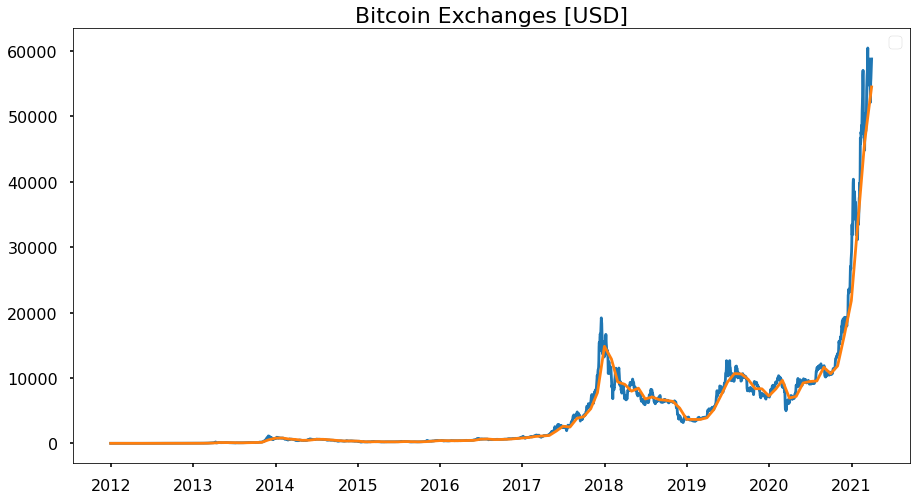

In [8]:
# Visualize
fig, ax = plt.subplots(figsize = (15, 8))
plt.plot(df_day["Close"])
plt.plot(df_month["Close"])
plt.title("Bitcoin Exchanges [USD]", fontsize=22)
plt.legend();

## `df_day` looks too noisy compare to `df_month` and will not be good for our model. 
- Confirm both

In [9]:
print(df_day.shape)
df_day.head()

(3379, 7)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370
2012-01-01,4.765576,4.765576,4.765576,4.765576,6.790640,32.971105,4.765576
2012-01-02,5.006549,5.006549,5.006549,5.006549,15.183373,75.932706,5.006549
2012-01-03,5.206530,5.206530,5.206530,5.206530,7.917041,40.795994,5.206530
2012-01-04,5.202511,5.241699,5.202511,5.241699,13.659736,72.860096,5.216680


In [10]:
print(df_month.shape)
df_month.head()

(112, 7)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.476415,4.478946,4.476415,4.478946,17.940426,79.495594,4.477370
2012-01-31,6.205873,6.208926,6.203568,6.206636,5.062630,30.557645,6.205749
2012-02-29,5.239485,5.240140,5.237452,5.238107,8.246900,42.804255,5.238445
2012-03-31,4.956081,4.956802,4.950829,4.951425,13.496505,67.005496,4.954135
2012-04-30,4.980339,4.981768,4.978907,4.980228,18.311532,90.911425,4.980298


In [11]:
df_day.isnull().sum()

Open                 3
High                 3
Low                  3
Close                3
Volume_(BTC)         3
Volume_(Currency)    3
Weighted_Price       3
dtype: int64

In [12]:
df_day[df_day.isnull().any(axis = 1)]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Replace missing value

In [13]:
# Replace missing value
df_day.fillna(method = "ffill", inplace = True)

# Confirm changes
df_day[df_day.isnull().any(axis = 1)]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,


## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=1.000000


<Figure size 1080x504 with 0 Axes>

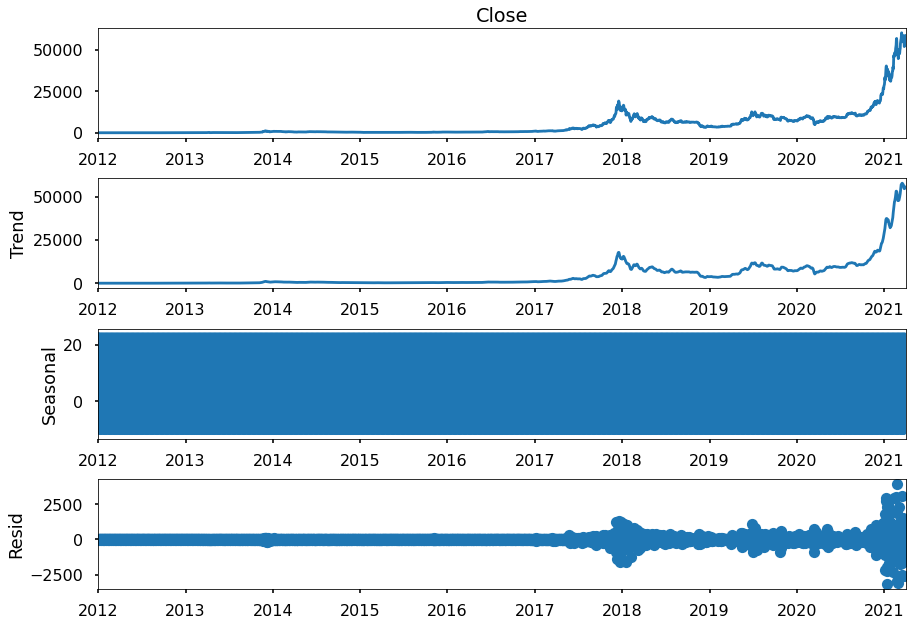

In [14]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_day.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_day.Close)[1])

plt.show();

### This is not looking great, let me test for the monthly trend

In [15]:
df_month.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

Dickey–Fuller test: p=0.998835


<Figure size 1080x576 with 0 Axes>

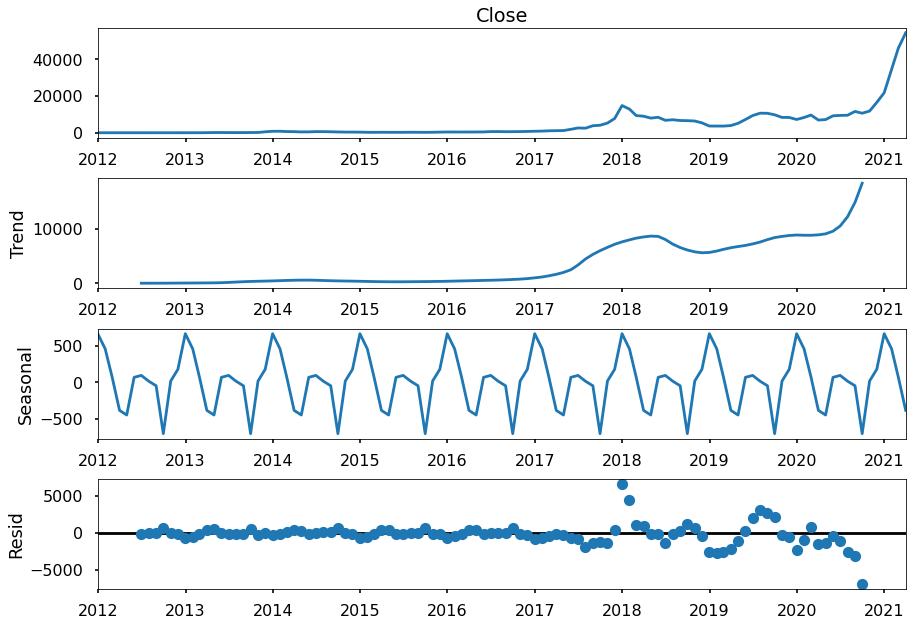

In [16]:
plt.figure(figsize=[15,8])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show();

## Looks better. Hence I will stick to this

- Adjust to get a p value of < 0.05. That is, make the data stationary
- Subset only the 'Weighted_Price_box' column

In [17]:
df_subset = df_month["Weighted_Price"]
df_subset.head()

Timestamp
2011-12-31    4.477370
2012-01-31    6.205749
2012-02-29    5.238445
2012-03-31    4.954135
2012-04-30    4.980298
Freq: M, Name: Weighted_Price, dtype: float64

In [18]:
#Determine rolling statistics
rolmean = df_subset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df_subset.rolling(window=12).std()

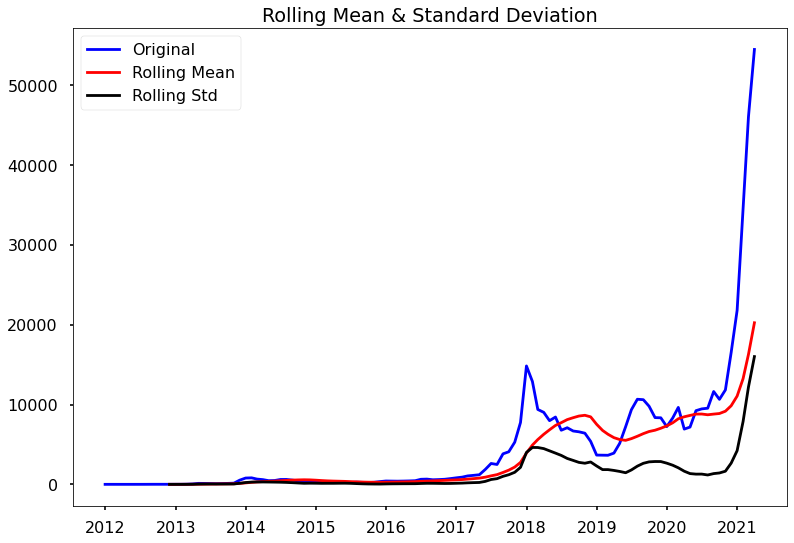

In [19]:
#Plot rolling statistics
orig = plt.plot(df_subset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

The graph above demonstrates that, despite the rolling standard deviation being largely steady over time, the rolling mean has a trend component. Our rolling statistics, such as mean and standard deviation, must be constant over time for our time series to be stationary. As a result, both curves must be parallel to the x-axis, which is not the case in our example.

To further augment that the time series is not stationary, let us perform the ADCF test.

In [20]:
# Create unction to chesck for stationarity
def check_stationarity(df):
    #Determine rolling statistics
    movingAverage = df.rolling(window=12).mean()
    movingSTD = df.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Dickey Fuller Test:')
    adft = adfuller(df)
    adft2 = pd.Series(adft[0:4], index=['Test Statistic','p-value','#Lags Used','n_observations'])
    for key,value in adft[4].items():
        adft2['Critical Value (%s)'%key] = value
    return adft2

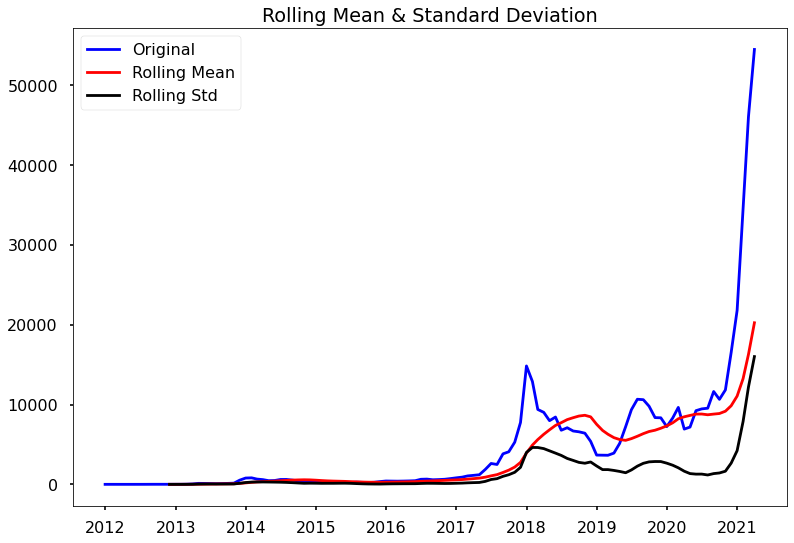

Dickey Fuller Test:


Test Statistic            2.146295
p-value                   0.998835
#Lags Used                1.000000
n_observations          110.000000
Critical Value (1%)      -3.491245
Critical Value (5%)      -2.888195
Critical Value (10%)     -2.580988
dtype: float64

In [21]:
check_stationarity(df_subset)

The following conditions must be met by the ADCF test for a time series to be stationary:
- p-value 0.05
- critical values very close to the test statistics

We can reasonably conclude that our time series is not stationary because our data do not meet these conditions. Hence the need for transformation. Here are some common methods for transforming time series data to make it more stationary:
- Box-Cox transformation
- Log transformation
- Seasonal decomposition
- Detrending
- Differencing

## Log Scale Transformation
I am starting with Log transformation because the data shows some level of heteroscedasticity. Heteroscedasticity is a time series data characteristic where the variance changes over time.

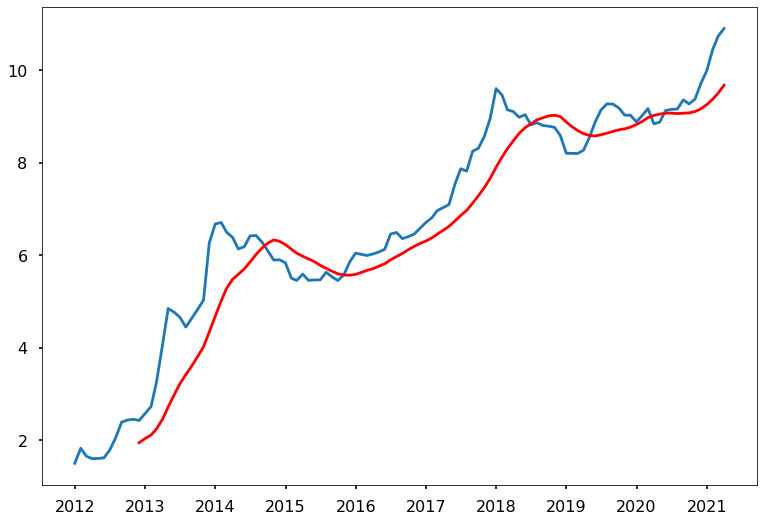

In [22]:
#Estimating trend
dfLogScale = np.log(df_subset)

#Find the MA
movingAverage = dfLogScale.rolling(window=12).mean()
movingSTD = dfLogScale.rolling(window=12).std()
plt.plot(dfLogScale)
plt.plot(movingAverage, color='red');

Since both the dfLogScale and the movingAverage show trend, removing one from the other should remove or reduce the trend in the data

In [23]:
dfDetrend = dfLogScale - movingAverage
#Drop missing values
dfDetrend.dropna(inplace=True)
dfDetrend.head()

Timestamp
2012-11-30    0.481795
2012-12-31    0.541000
2013-01-31    0.617725
2013-02-28    1.006842
2013-03-31    1.596602
Freq: M, Name: Weighted_Price, dtype: float64

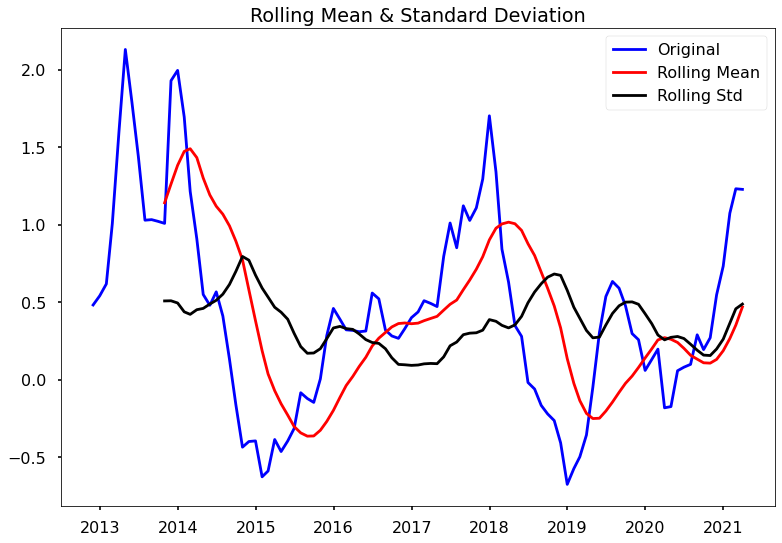

Dickey Fuller Test:


Test Statistic          -3.410693
p-value                  0.010600
#Lags Used               7.000000
n_observations          93.000000
Critical Value (1%)     -3.502705
Critical Value (5%)     -2.893158
Critical Value (10%)    -2.583637
dtype: float64

In [24]:
check_stationarity(dfDetrend)

> Following the transformation:
- The p-value dropped from 0.999 to 0.011 which is below 0.05
- The important values for the confidence intervals of 1%, 5%, and 10% are fairly near the test statistic.
- As a result of the first two points, we can conclude that the provided series is stationary.
- Perform seasonal decomposition

> Other transformation like exponential decomposition can also be done to increase accuracy

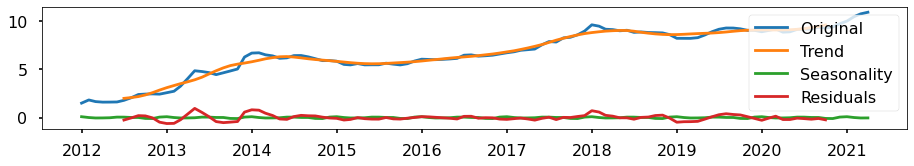

In [25]:
decomposition = seasonal_decompose(dfLogScale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dfLogScale, label='Original')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

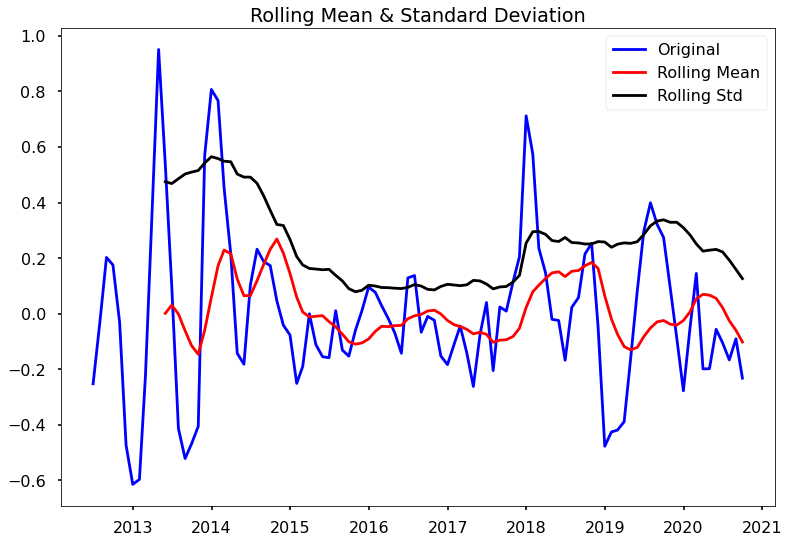

Dickey Fuller Test:


Test Statistic          -3.474170
p-value                  0.008676
#Lags Used               7.000000
n_observations          92.000000
Critical Value (1%)     -3.503515
Critical Value (5%)     -2.893508
Critical Value (10%)    -2.583824
dtype: float64

In [26]:
#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
dfDecomposed = residual
dfDecomposed.dropna(inplace=True)
check_stationarity(dfDecomposed)

> Following the transformation:
- The p-value dropped from 0.011 to 0.009 which is below 0.05
- The important values for the confidence intervals of 1%, 5%, and 10% are fairly near the test statistic.

## Build Model
> Find the best vaalues for p, q and d and use it to buid the model

In [27]:
# Initial approximation of parameters
Q = range(0, 2)
q = range(0, 3)
P = range(0, 3)
p = range(0, 3)
D=1
d=1
params = product(p, q, P, Q)
param_list = list(params)
len(param_list)

# Model Selection
results = []
best_aic = float("inf")
for param in param_list:
    try:
        model=sm.tsa.statespace.SARIMAX(dfLogScale, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [28]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

,parameters,aic
49,"(2, 2, 0, 1)",15.733312
19,"(1, 0, 0, 1)",15.757752
21,"(1, 0, 1, 1)",16.269812
37,"(2, 0, 0, 1)",17.228256
25,"(1, 1, 0, 1)",17.330015


## Evaluate

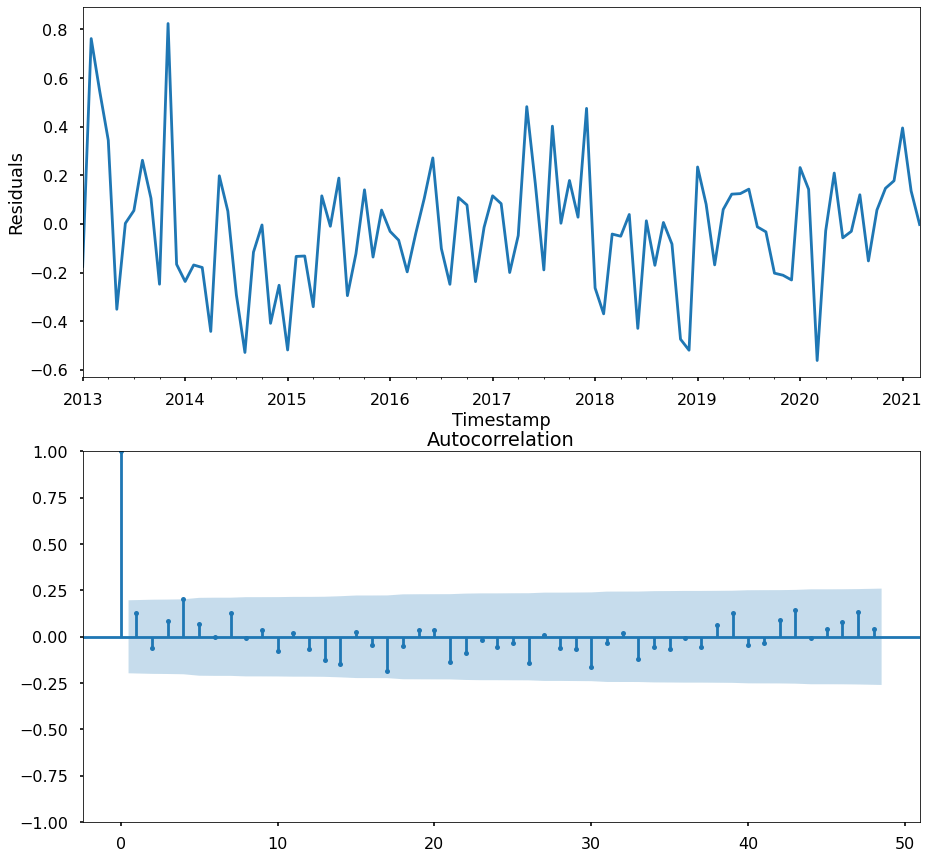

In [29]:
# STL-decomposition
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

## Prediction and visualization

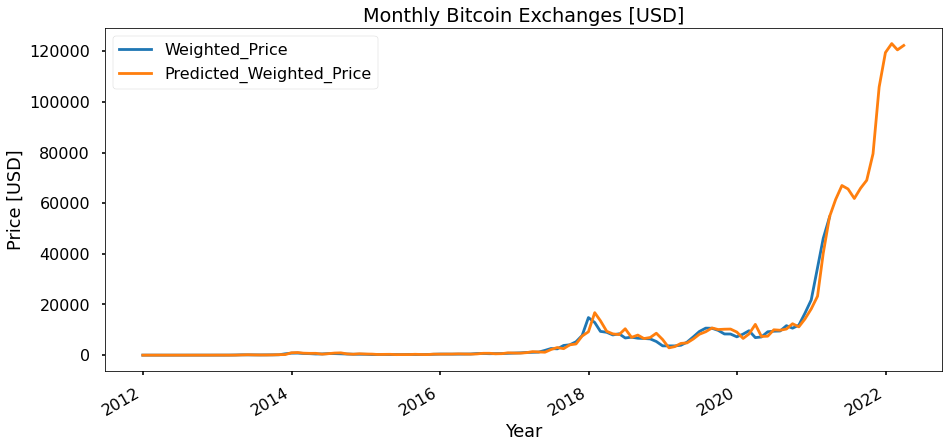

In [30]:
df_month2 = df_month[['Weighted_Price']]

# Forcast for a year. The start and end date can be modified
date = pd.to_datetime(pd.date_range('2021-03-15','2022-04-15', freq='M').strftime("%Y-%m-%d").tolist())
future = pd.DataFrame(index=date, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['Forecast'] = np.exp(best_model.predict(start=0, end=df_month2.shape[0]))

# Create a plot
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.Forecast.plot(color='C1', label='Predicted_Weighted_Price')

plt.title('Monthly Bitcoin Exchanges [USD]')
plt.xlabel('Year')
plt.ylabel('Price [USD]')
plt.legend();

# GARCH MODEL

Most of the points have been discussed above. Hence, I'll only be adding comments.

## Create the wrangle function

In [31]:
def wrangle(path):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    path : str
        The path to the data directory.

    Returns
    -------
    pd.DataFrame
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = pd.read_csv(path)

    # Interpolating Missing Values
    df = df.interpolate()
    
    # Change the timestamp column to datatime and set as index
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit='s')
    df.set_index("Timestamp", inplace = True)
    #resample to daily readings
    df = df.resample("D").mean()
                
    # Create the percentage change "return" column 
    df["return"] = df["Close"].pct_change() * 100
    df.dropna(inplace = True)

    # Return returns
    return df["return"]

In [32]:
df = wrangle("/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

Timestamp
2012-01-01     6.399499
2012-01-02     5.056517
2012-01-03     3.994399
2012-01-04     0.675480
2012-01-05    17.569486
Name: return, dtype: float64

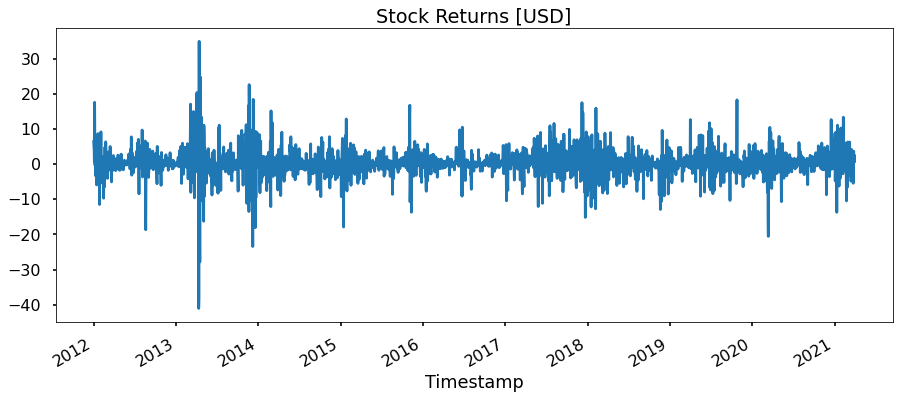

In [33]:
#  visualize
plt.figure(figsize = (15,6))
df.plot()
plt.title("Stock Returns [USD]");

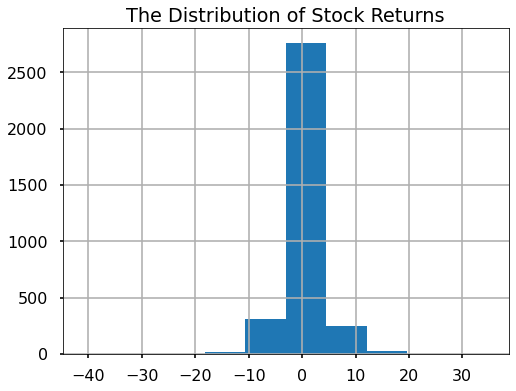

In [34]:
# Check the distribution of the data
plt.figure(figsize = (8,6))
plt.title("The Distribution of Stock Returns")
df.hist();

In [35]:
# Check the daily volatility by the standard deviation
daily_volatility = df.std()
daily_volatility

3.769168261874188

In [36]:
# Check the daily volatility
annual_volatility = df.std() * np.sqrt(252)
annual_volatility

59.83369122286007

In [37]:
# Check the moving average forecast
rolling_30d_volatility = df.rolling(window=30).std().dropna()
rolling_30d_volatility.head()

Timestamp
2012-01-30    5.704066
2012-01-31    5.623593
2012-02-01    5.567336
2012-02-02    5.755529
2012-02-03    5.757306
Name: return, dtype: float64

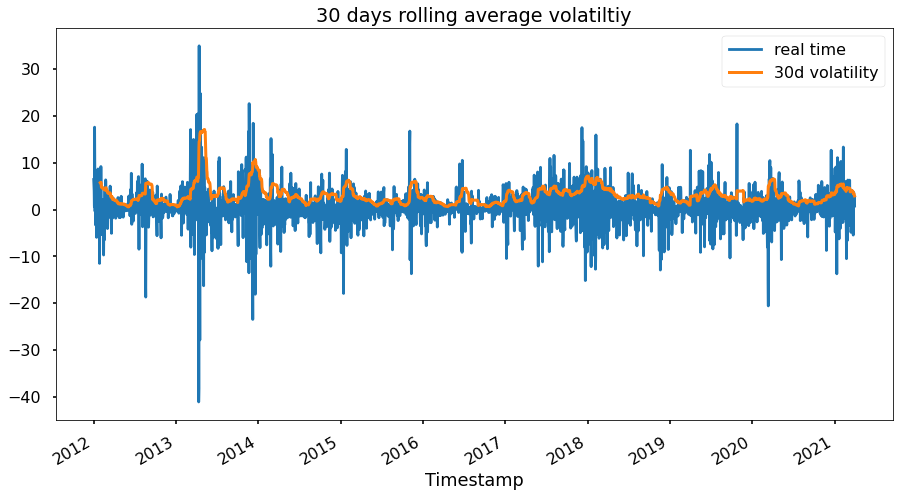

In [38]:
plt.figure(figsize = (15,8))
df.plot(label = "real time")
rolling_30d_volatility.plot(label = "30d volatility", linewidth = 3)
plt.title("30 days rolling average volatiltiy")
plt.legend();

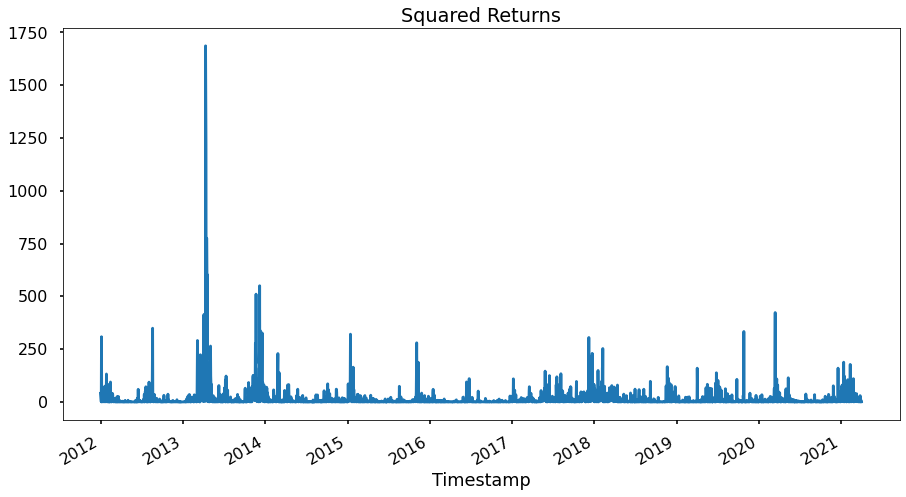

In [39]:
# Check if the data is fit for GARCH model
# Plot squared returns

plt.figure(figsize = (15, 8))
(df**2).plot()
plt.title("Squared Returns");

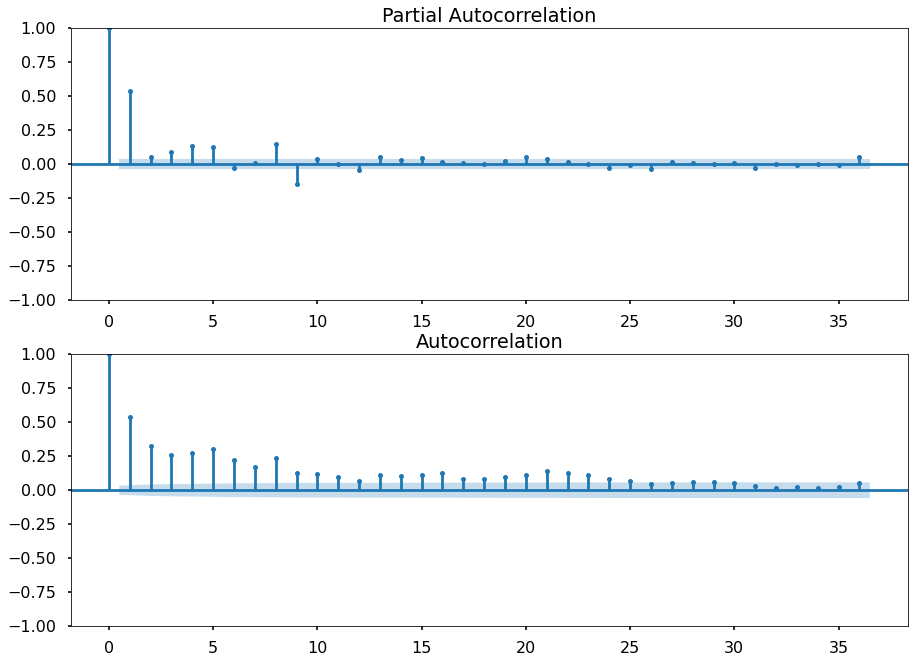

In [40]:
plt.figure(figsize=(15, 11))
ax = plt.subplot(211)
plot_pacf(df**2, ax = ax);

ax = plt.subplot(212)
plot_acf(df**2, ax = ax);

## Split data

In [41]:
cutoff = int(len(df) * 0.8)
df_train = df[:cutoff]
df_test = df[cutoff:]
print(
    f"""Total data: {df.shape[0]}
Train data: {df_train.shape[0]}
Test data: {df_test.shape[0]}"""
       )

Total data: 3375
Train data: 2700
Test data: 675


##  Build and train model
### Setting p and q to 1 give the best result most of the cases

In [42]:
# Build and train model
model = arch_model(
    df_train,
    p = 1,
    q = 1,
    rescale = False
).fit(disp = 0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6616.06
Distribution:                  Normal   AIC:                           13240.1
Method:            Maximum Likelihood   BIC:                           13263.7
                                        No. Observations:                 2700
Date:                Sun, Jan 01 2023   Df Residuals:                     2699
Time:                        01:11:53   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1782  4.165e-02      4.278  1.889e-05 [9.653e-02,  0.260]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3259      0.136      2.394  1.665e-02 [5.911e-02,  0.593]
alpha[1]       0.2501  3.530e-02      7.084  1.396e-12   [  0.181,  0.319]
beta[1]        0.7499  3.601e-02     20.827  2.470e-96   [  0.679,  0.820]
==========================================================================

Covariance estimator: robust
"""

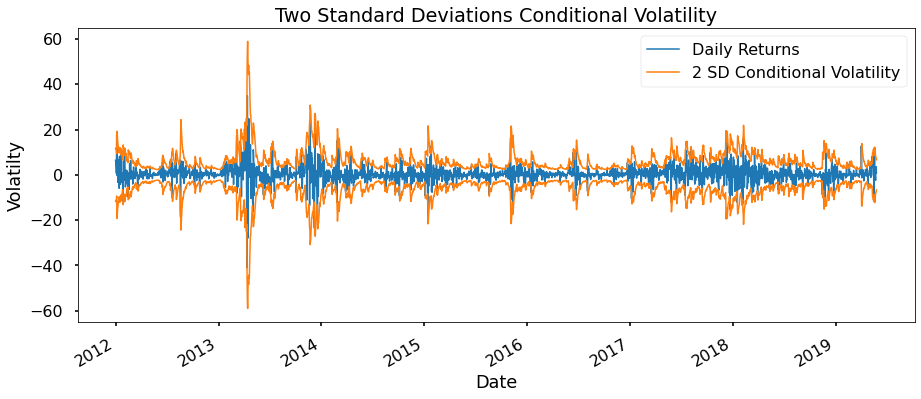

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))

# df_train
df_train.plot(ax = ax, label = "Daily Returns", linewidth = 1.5)

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax = ax, label = "2 SD Conditional Volatility", color = "C1", linewidth = 1.5
)


# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(
    ax = ax, color = "C1", linewidth = 1.5
)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Volatilty")

# Add title
plt.title ("Two Standard Deviations Conditional Volatility")

# Add legend
plt.legend();

The plot above shows that the two Standard Deviations Conditional Volatility lines captured both the upper and lower limits. Therefore it is safe to conclude that the model is performing well

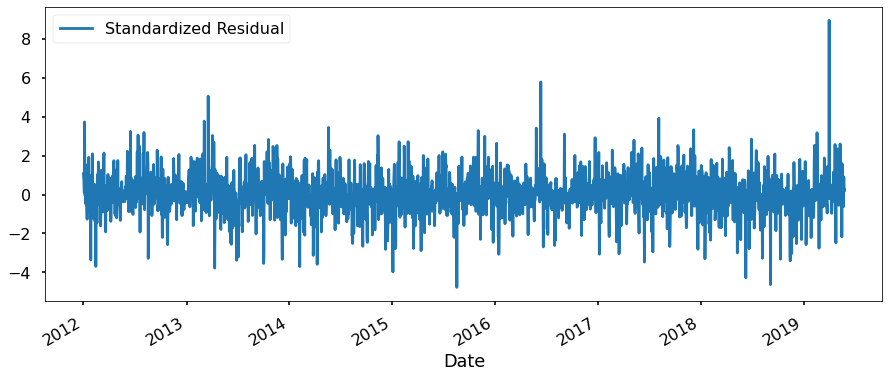

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax = ax, label = "Standardized Residual")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

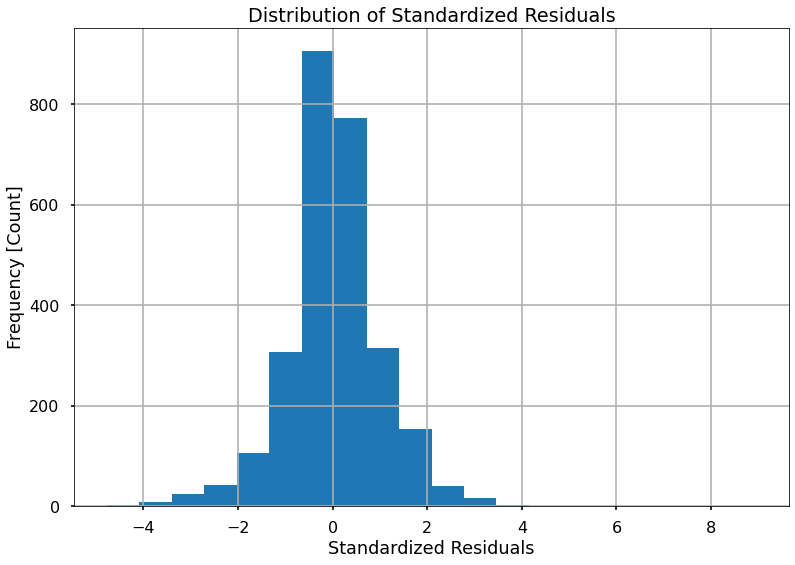

In [45]:
# Create histogram of standardized residuals, 20 bins
model.std_resid.hist(bins = 20)

# Add axis labels
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency [Count]")

# Add title
plt.title("Distribution of Standardized Residuals");

The plot above shows a normal distribution of the data. Therefore it is safe to conclude that the model is performing well

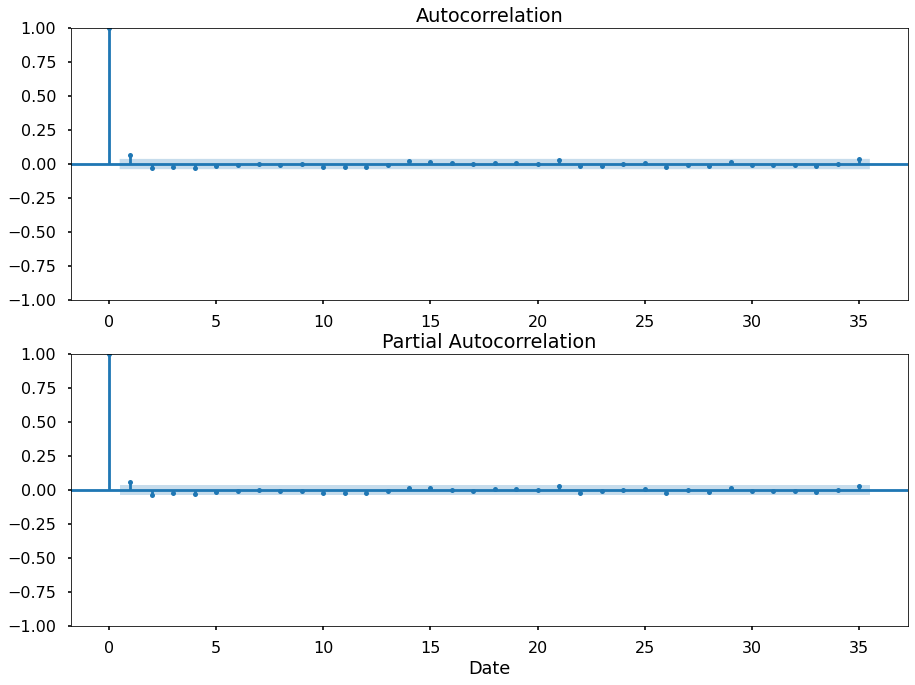

In [46]:
#  Check for the performance of the model
plt.figure(figsize=(15, 11))

# Create ACF and PACF of squared, standardized residuals
ax = plt.subplot(211)
plot_acf(model.std_resid**2, ax =ax)

ax = plt.subplot(212)
plot_pacf(model.std_resid**2, ax =ax)

# Add axis labels
plt.xlabel("Date");

In [47]:
# Predict for five days
five_days_forecast = model.forecast(horizon = 5, reindex = False).variance
np.sqrt(five_days_forecast)

,h.1,h.2,h.3,h.4,h.5
Timestamp,,,,,
2019-05-26,2.966146,3.020583,3.074056,3.126615,3.178304


## Evaluate Model

In [48]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(df) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = df.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(
        y_train,
        p = 1,
        q= 1,
        rescale = False
    ).fit(disp = 0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon = 1, reindex = False).variance.iloc[0,0]**0.5
    

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=df.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (675,)


Timestamp
2019-05-27    2.966146
2019-05-28    4.740716
2019-05-29    4.172187
2019-05-30    3.704389
2019-05-31    3.268327
dtype: float64

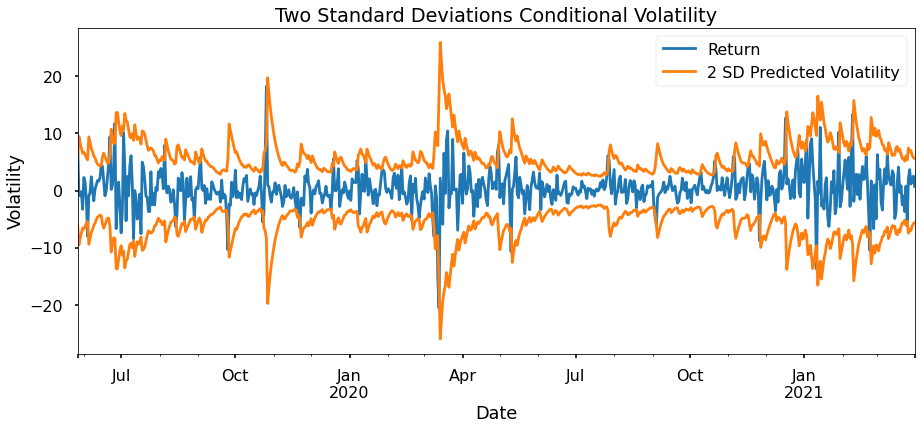

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
df.tail(test_size).plot(ax=ax, label="Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv.rename("")).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Volatility")

# Add title
plt.title ("Two Standard Deviations Conditional Volatility")

# Add legend
plt.legend();

### The model seems to capture the flunctuation in the trend

## Communication

In [50]:
def predict(model=model, horizon = 30, reindex=False):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    model : model to be used
    horizon: number of predictions
    reindex: set to False
    
    Returns
    -------
    pd.DataFrame
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Predict
    prediction = model.forecast(horizon=horizon, reindex=reindex).variance ** 0.5
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days = 1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]
    
    # Parse the date strings and extract the date portion
    dates = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").date() for date in prediction_index]

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten()

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data = data, index= dates)
    
    # Convert Series to Dataframe
    df = prediction_formatted.to_frame(name = "Return")
    df.index.name = "Timestamp"

    # Return Series as dictionary
    return df

In [51]:
predict(horizon = 10)

,Return
Timestamp,
2021-03-31,2.817417
2021-04-01,2.880405
2021-04-02,2.942045
2021-04-05,3.002419
2021-04-06,3.061603
2021-04-07,3.119665
2021-04-08,3.176666
2021-04-09,3.232661
2021-04-12,3.287704
